# Project #3. “E.coli outbreak investigation”

**Day 1. 04.12.2020**

# 0. Import python libs

In [3]:
import pandas as pd
import numpy as np

## 1. Exploring the dataset

### 1.1. Download data

Dowload SRR292678 - paired end, insert size 470 bp

* Forward reads
`wget https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292678sub_S1_L001_R1_001.fastq.gz`

* Reverse reads
`wget https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292678sub_S1_L001_R2_001.fastq.gz`

Dowload SRR292862 – mate pair, insert size 2 kb

* Forward reads
`wget https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292862_S2_L001_R1_001.fastq.gz`

* Reverse reads
`wget https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292862_S2_L001_R2_001.fastq.gz`

Dowload SRR292770 – mate pair, insert size 6 kb

* Forward reads
`wget https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292770_S1_L001_R1_001.fastq.gz`

* Reverse reads
`wget https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292770_S1_L001_R2_001.fastq.gz`

### 1.2. Unzip

`gzip -d SRR292678sub_S1_L001_R1_001.fastq.gz SRR292678sub_S1_L001_R2_001.fastq.gz SRR292862_S2_L001_R1_001.fastq.gz SRR292862_S2_L001_R2_001.fastq.gz SRR292770_S1_L001_R1_001.fastq.gz SRR292770_S1_L001_R2_001.fastq.gz`

### 1.3. FastQC reports

Run FastQC to generate reports

`fastqc -o . SRR292678sub_S1_L001_R1_001.fastq SRR292678sub_S1_L001_R2_001.fastq SRR292862_S2_L001_R1_001.fastq SRR292862_S2_L001_R2_001.fastq SRR292770_S1_L001_R1_001.fastq SRR292770_S1_L001_R2_001.fastq`

Number of reads:

SRR292678 - paired end, insert size 470 bp

* Forward reads: 5499346
* Reverse reads: 5499346

SRR292862 – mate pair, insert size 2 kb

* Forward reads: 5102041
* Reverse reads: 5102041

SRR292770 – mate pair, insert size 6 kb

* Forward reads: 5102041
* Reverse reads: 5102041

## 2. K-mer profile and genome size estimation

To count kmers, we will use the [Jellyfish](http://www.cbcb.umd.edu/software/jellyfish/)

### 2.1. Install Jellyfish

`brew tap Brewsci/bio`

`brew install jellyfish`

### 2.2. k-mers count

The “jellyfish count” command takes the following options:
* -m or “mer” specifies the length
* -C tells it to ignore directionality (it treats each read the same as its reverse complement).
* -s is an initial estimate for the size of the hash table jellyfish uses, set > genome size
* -o specifies the name of the output file. choose a name with the k-mer length in it.

Run "jellyfish count" command

`jellyfish count -m 31 -C -s 5499346 -o kmer SRR292678sub_S1_L001_R1_001.fastq`

Create histogram file

`jellyfish histo kmer > kmerhist.txt`

### 2.3. Visualize k-mer distribution

<AxesSubplot:xlabel='0'>

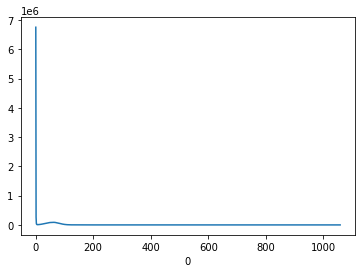

In [35]:
kmerhistdf = pd.read_csv('data/kmerhist.txt', header=None, index_col=0, sep=' ')
kmerhistdf[1][0:].plot()

We can find the border of the initial peak corresponding to sequence errors at 5

<AxesSubplot:xlabel='0'>

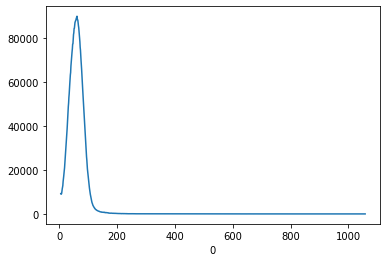

In [5]:
bord = 5
kmerhistdf[1][bord:].plot()

### 2.4. Estimate the genome size

To estimate the genome size we will use the method from [here](http://koke.asrc.kanazawa-u.ac.jp/HOWTO/kmer-genomesize.html):

In [6]:
round((kmerhistdf[5:].index * kmerhistdf[5:][1]).sum() / kmerhistdf.index[np.argmax(kmerhistdf[1][bord:]) + bord])

5199855

## 3. Assembling E. coli X genome from paired reads

### 3.1. Dowload and unpack SPAdes

Download SPAdes from: http://cab.spbu.ru/software/spades/

Unpack:

`tar -xzf SPAdes-3.14.1-Darwin.tar`

Test:

`spades.py --test`

### 3.2. Assembling genome from the library SRR292678

Run command:

`spades.py --pe1-1 SRR292678sub_S1_L001_R1_001.fastq --pe1-2 SRR292678sub_S1_L001_R2_001.fastq -o assemblySRR292678`

### 3.3. Quality of the resulting assembly

We use [QUAST](http://cab.cc.spbu.ru/quast/) online tool on scaffolds.fasta and contigs.fasta

Result for scaffolds.fasta:

<img src="img/1_1lib_scaffolds_QUAST.png">

Result for contigs.fasta:

<img src="img/1_1lib_contigs_QUAST.png">

### 3.4. Effect of read correction

Now use jellyfish on corrected files 

Run "jellyfish count" command

`jellyfish count -m 31 -C -s 5499346 -o kmercorrected assemblySRR292678/corrected/SRR292678sub_S1_L001_R1_001.00.0_0.cor.fastq`

Create histogram file

`jellyfish histo kmercorrected > kmercorrectedhist.txt`

<AxesSubplot:xlabel='0'>

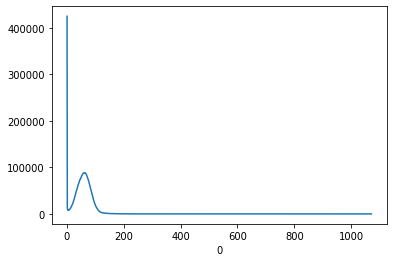

In [10]:
kmerhistdf = pd.read_csv('data/kmercorrectedhist.txt', header=None, index_col=0, sep=' ')
kmerhistdf[1][0:].plot()

We can see that there are fewer low frequent reads in corrected reads, which are related to sequencing errors

## 4. Impact of reads with large insert size

Now we run SPAdes again by consolidating three libraries. We use all three libraries: SRR292678 as a paired ends,  SRR292862 and SRR292770 as a mate pairs.

`spades.py --pe1-1 SRR292678sub_S1_L001_R1_001.fastq --pe1-2 SRR292678sub_S1_L001_R2_001.fastq --mp1-1 SRR292862_S2_L001_R1_001.fastq --mp1-2 SRR292862_S2_L001_R2_001.fastq --mp2-1 SRR292770_S1_L001_R1_001.fastq --mp2-2 SRR292770_S1_L001_R2_001.fastq -o assembly2`

Again use QUAST tool on scaffolds.fasta and contigs.fasta

Result for scaffolds.fasta:

<img src="img/1_3lib_scaffolds_QUAST.png">

Result for contigs.fasta:

<img src="img/1_3lib_contigs_QUAST.png">

We can see that N50 become higher, it happened through the use of mate pairs, which increases assembly accuracy when solving repeats.

## 5. Genome Annotation

Install Prokka:

`brew install prokka`

Run Prokka:

`prokka scaffolds.fasta --centre X --compliant`

## 6. Finding the closest relative of E. coli X

### 6.1. Locate 16S rRNA in the assembled E. coli X genome

Run barrnap to find the location of ribosomal RNA genes:

`barrnap scaffolds.fasta > ribosomal_rna_search`

Look at result:

`cat ribosomal_rna_search`

Output:

`
##gff-version 3
NODE_184_length_223_cov_0.720238_ID_565088	barrnap:0.9	rRNA	95	205	5.6e-18	-	.	Name=5S_rRNA;product=5S ribosomal RNA
NODE_1_length_2815616_cov_74.3819_ID_564387	barrnap:0.9	rRNA	322892	323002	2.2e-11	-	.	Name=5S_rRNA;product=5S ribosomal RNA
NODE_1_length_2815616_cov_74.3819_ID_564387	barrnap:0.9	rRNA	323101	326001	0	-	.	Name=23S_rRNA;product=23S ribosomal RNA
NODE_1_length_2815616_cov_74.3819_ID_564387	barrnap:0.9	rRNA	326359	327896	0	-	.	Name=16S_rRNA;product=16S ribosomal RNA
NODE_1_length_2815616_cov_74.3819_ID_564387	barrnap:0.9	rRNA	592162	592272	6.1e-11	-	.	Name=5S_rRNA;product=5S ribosomal RNA
NODE_1_length_2815616_cov_74.3819_ID_564387	barrnap:0.9	rRNA	592407	592517	2.2e-11	-	.	Name=5S_rRNA;product=5S ribosomal RNA
NODE_1_length_2815616_cov_74.3819_ID_564387	barrnap:0.9	rRNA	592616	595516	0	-	.	Name=23S_rRNA;product=23S ribosomal RNA
NODE_1_length_2815616_cov_74.3819_ID_564387	barrnap:0.9	rRNA	595966	597503	0	-	.	Name=16S_rRNA;product=16S ribosomal RNA
NODE_1_length_2815616_cov_74.3819_ID_564387	barrnap:0.9	rRNA	2500844	2500954	2.2e-11	-	.	Name=5S_rRNA;product=5S ribosomal RNA
NODE_1_length_2815616_cov_74.3819_ID_564387	barrnap:0.9	rRNA	2501053	2503953	0	-	.	Name=23S_rRNA;product=23S ribosomal RNA
NODE_1_length_2815616_cov_74.3819_ID_564387	barrnap:0.9	rRNA	2504403	2505940	0	-	.	Name=16S_rRNA;product=16S ribosomal RNA
NODE_5_length_236041_cov_85.7779_ID_563492	barrnap:0.9	rRNA	43835	45372	0	+	.	Name=16S_rRNA;product=16S ribosomal RNA
NODE_5_length_236041_cov_85.7779_ID_563492	barrnap:0.9	rRNA	45873	48630	0	+	.	Name=23S_rRNA;product=23S ribosomal RNA
NODE_5_length_236041_cov_85.7779_ID_563492	barrnap:0.9	rRNA	48983	49084	5.5e-10	+	.	Name=5S_rRNA;product=5S ribosomal RNA
NODE_5_length_236041_cov_85.7779_ID_563492	barrnap:0.9	rRNA	85462	86999	0	+	.	Name=16S_rRNA;product=16S ribosomal RNA
NODE_5_length_236041_cov_85.7779_ID_563492	barrnap:0.9	rRNA	87500	90257	0	+	.	Name=23S_rRNA;product=23S ribosomal RNA
NODE_5_length_236041_cov_85.7779_ID_563492	barrnap:0.9	rRNA	90356	90466	2.2e-11	+	.	Name=5S_rRNA;product=5S ribosomal RNA
NODE_6_length_209194_cov_80.6603_ID_563563	barrnap:0.9	rRNA	111955	113492	0	+	.	Name=16S_rRNA;product=16S ribosomal RNA
NODE_6_length_209194_cov_80.6603_ID_563563	barrnap:0.9	rRNA	113850	116750	0	+	.	Name=23S_rRNA;product=23S ribosomal RNA
NODE_6_length_209194_cov_80.6603_ID_563563	barrnap:0.9	rRNA	116849	116959	2.2e-11	+	.	Name=5S_rRNA;product=5S ribosomal RNA
NODE_71_length_720_cov_1.1218_ID_565136	barrnap:0.9	rRNA	314	719	9.8e-23	+	.	Name=16S_rRNA;product=16S ribosomal RNA (partial);note=aligned only 25 percent of the 16S ribosomal RNA
NODE_9_length_87669_cov_86.9393_ID_563775	barrnap:0.9	rRNA	84700	84810	2.2e-11	-	.	Name=5S_rRNA;product=5S ribosomal RNA
NODE_9_length_87669_cov_86.9393_ID_563775	barrnap:0.9	rRNA	84909	87664	0	-	.	Name=23S_rRNA;product=23S ribosomal RNA
`

Now we find the sequence of 16S ribosomal RNA

In [31]:
seq = ''
with open('data/scaffolds.fasta') as f:
    seq = f.read()
seq = ''.join(seq.split('\n')[1:])

In [32]:
seq[326359:327896]

'AGGAGGTGATCCAACCGCAGGTTCCCCTACGGTTACCTTGTTACGACTTCACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTAAGCTACCTACTTCTTTTGCAACCCACTCCCATGGTGTGACGGGCGGTGTGTACAAGGCCCGGGAACGTATTCACCGTGGCATTCTGATCCACGATTACTAGCGATTCCGACTTCATGGAGTCGAGTTGCAGACTCCAATCCGGACTACGACGCACTTTATGAGGTCCGCTTGCTCTCGCGAGGTCGCTTCTCTTTGTATGCGCCATTGTAGCACGTGTGTAGCCCTGGTCGTAAGGGCCATGATGACTTGACGTCATCCCCACCTTCCTCCAGTTTATCACTGGCAGTCTCCTTTGAGTTCCCGGCCGGACCGCTGGCAACAAAGGATAAGGGTTGCGCTCGTTGCGGGACTTAACCCAACATTTCACAACACGAGCTGACGACAGCCATGCAGCACCTGTCTCACGGTTCCCGAAGGCACATTCTCATCTCTGAAAACTTCCGTGGATGTCAAGACCAGGTAAGGTTCTTCGCGTTGCATCGAATTAAACCACATGCTCCACCGCTTGTGCGGGCCCCCGTCAATTCATTTGAGTTTTAACCTTGCGGCCGTACTCCCCAGGCGGTCGACTTAACGCGTTAGCTCCGGAAGCCACGCCTCAAGGGCACAACCTCCAAGTCGACATCGTTTACGGCGTGGACTACCAGGGTATCTAATCCTGTTTGCTCCCCACGCTTTCGCACCTGAGCGTCAGTCTTCGTCCAGGGGGCCGCCTTCGCCACCGGTATTCCTCCAGATCTCTACGCATTTCACCGCTACACCTGGAATTCTACCCCCCTCTACGAGACTCAAGCTTGCCAGTATCAGATGCAGTTCCCAGGTTGAGCCCGGGGATTTCACATCTGACTTAACAAACCGCCTGCGTGCGCTTTACGCCCAGTAATTCCGATTAACGCTTGCAC

### 6.2. Use BLAST to search for the genome in the RefSeq database

Run BLAST (http://blast.ncbi.nlm.nih.gov/):

<img src="img/blastn.png">

As a result we have 100% match with NC_011748.1 Escherichia coli 55989, complete genome.

Next, we download genome sequence by link: https://www.ncbi.nlm.nih.gov/nuccore/NC_011748.1?report=fasta

## 7. What is the genetic cause of HUS?

We will now analyze the genome-wide alignment of E. coli X and reference genome. We use Mauve tool for it. 

We select reference genome sequence and annotated E. coli X genome as input files and search for shiga toxin-related genes.

<img src="img/Mauve1.png">

We find two shiga toxin-related genes:

* stxB (3483605 - 3483874), length: 270
* stxA (3483886 - 3484845), length: 960

## 8. Tracing the source of toxin genes in E. coli X

On both sides of shiga toxin-related genes we can find phage proteins. So we can consider that the origin of these toxin genes in E.coli X is phage.

<img src="img/Mauve2.png">

## 9. Antibiotic resistance detection

To search for genes responsible for antibiotic resistance, we use [ResFinder](https://cge.cbs.dtu.dk/services/ResFinder/)

Results for E.coli X:

<img src="img/ResFinder1a.png">

Results for reference:

<img src="img/ResFinder2.png">

We find resistance to:

| Antimicrobial | Class | Genetic background |
| --- | --- | --- |
|ampicillin | beta-lactam | blaTEM-1B (blaTEM-1B_AY458016), blaCTX-M-15 (blaCTX-M-15_AY044436)|
| cefepime | beta-lactam | blaCTX-M-15 (blaCTX-M-15_AY044436) |
|cefotaxime | beta-lactam | blaCTX-M-15 (blaCTX-M-15_AY044436) |
|ceftazidime | beta-lactam | blaCTX-M-15 (blaCTX-M-15_AY044436)
|sulfamethoxazole | folate pathway antagonist | sul1 (sul1_DQ914960), sul2 (sul2_HQ840942), sul1 (sul1_AY522923), |sul1 (sul1_AY115475), sul1 (sul1_U12338)|
|tetracycline | tetracycline | tet(A) (tet(A)_AJ517790) |
|trimethoprim | folate pathway antagonist | dfrA7 (dfrA7_AB161450) |

Reference also resistant to tetracycline.

## 10. Antibiotic resistance mechanism

Now we search for β-lactamase enzymes using Mauve tool.

We find:

* ampC gene (4758802 – 4759935) – on the left we find frdA, frdB, frdC, frdD genes
* bla_1 gene (5195566 - 5196441) – on the left we find Tn3 family tranposase
* bla_2 gene (5199263 - 5200123) – on the left there is tnpR_1 gene